In [4]:
import pandas as pd
import scipy.io
import numpy as np
import scipy.sparse
import src.preprocessing.data_cleaning as data_cleaning
import src.preprocessing.normalization as normalization
import src.preprocessing.feature_selection as feature_selection
import src.preprocessing.dim_reduction as dim_reduction
import src.analysis.clustering as clustering
import src.analysis.cell_identification as cell_identification
import src.evaluation.evaluation as evaluation
from importlib import reload

metadata_path = "./data/Tumor/metadata_all.csv"
true_labels = evaluation.load_true_labels(metadata_path, "Unnamed: 0", "celltype_major", ",")
print(true_labels.info())
print(true_labels.head())
reload(data_cleaning)

def load_expression_data_from_mtx(path, matrix_name, genes_name, barcodes_name, barcodes_labeled=None, n_sample=None, random_state=None):
    """
    Load gene expression data from MTX format into a sparse DataFrame.

    Parameters:
    - path: str, path to the folder with the matrix, genes and barcodes.

    Returns:
    - expression_matrix: Sparse DataFrame containing gene expression data.
    """
    # Load expression matrix
    matrix = scipy.io.mmread(path+matrix_name).tocsc()

    # Load genes
    genes = pd.read_csv(path+genes_name, header=0, sep='\t', names=['gene_symbol'])

    # Load barcodes
    barcodes = pd.read_csv(path+barcodes_name, header=0, sep='\t', names=['barcode'])

    # Filter by labeled barcodes if barcodes_labeled is provided
    if barcodes_labeled is not None:
        if 'barcode' not in barcodes_labeled.columns:
            raise ValueError("The provided barcodes_labeled DataFrame must contain a 'barcode' column.")
        # Find the intersection of barcodes
        labeled_barcodes = set(barcodes_labeled['barcode'])
        matching_indices = barcodes['barcode'].isin(labeled_barcodes)
        matrix = matrix[:, matching_indices]
        barcodes = barcodes[matching_indices]

    # Apply random sampling to barcodes if n_sample is specified
    if n_sample is not None and n_sample < len(barcodes):
        np.random.seed(random_state)
        sampled_indices = np.random.choice(len(barcodes), size=n_sample, replace=False)
        matrix = matrix[:, sampled_indices]  # Subset columns (barcodes)
        barcodes = barcodes.iloc[sampled_indices]

    # Transform sparse matrix into pandas sparse DataFrame
    expression_matrix = pd.DataFrame.sparse.from_spmatrix(matrix)
    expression_matrix.index = genes['gene_symbol']
    expression_matrix.columns = barcodes['barcode']

    expression_matrix = data_cleaning.remove_duplicated_genes(expression_matrix)

    return expression_matrix

expression_matrix = load_expression_data_from_mtx("./data/Tumor/",
                                                  matrix_name = "all_matrix.mtx", genes_name = "all_genes.tsv", barcodes_name = "all_barcodes.tsv",
                                                  barcodes_labeled=None, n_sample=None, random_state=6)

print(expression_matrix.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72410 entries, 0 to 72409
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   barcode     72410 non-null  object
 1   true_label  72410 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None
                    barcode   true_label
0  CID3586_AAGACCTCAGCATGAG  Endothelial
1  CID3586_AAGGTTCGTAGTACCT  Endothelial
2  CID3586_ACCAGTAGTTGTGGCC  Endothelial
3  CID3586_ACCCACTAGATGTCGG  Endothelial
4  CID3586_ACTGATGGTCAACTGT  Endothelial
<class 'pandas.core.frame.DataFrame'>
Index: 29172 entries, A1BG to bP-2189O9.3
Columns: 72410 entries, CID3586_AAACCTGAGAGTAATC to CID4535_TTTGTCATCTTTAGTC
dtypes: Sparse[int64, 0](72410)
memory usage: 1.4+ GB
None


In [17]:
# Supongamos que tienes una matriz CSC
csc_matrix = expression_matrix.sparse.to_coo().tocsc()  # 'data' es tu DataFrame de entrada

# Total de elementos en la matriz
total_elements = csc_matrix.shape[0] * csc_matrix.shape[1]

# Elementos no cero
non_zeros = csc_matrix.getnnz()

# Elementos cero
zeros = total_elements - non_zeros
print(f"Total elements : {total_elements}")
print(f"Número de ceros: {zeros}")

Total elements : 2112344520
Número de ceros: 1988814634


In [5]:
duplicated_genes = expression_matrix.index[expression_matrix.index.duplicated()]
if len(duplicated_genes) > 0:
    print(f"Genes duplicados encontrados: {duplicated_genes}")

zero_rows = expression_matrix[(expression_matrix == 0).all(axis=1)]
if len(zero_rows) > 0:
    print(f"Filas con todos ceros encontradas: {zero_rows.index}")

print(true_labels['true_label'].unique())

['Endothelial' 'CAFs' 'PVL' 'B-cells' 'T-cells' 'Myeloid'
 'Normal Epithelial' 'Plasmablasts' 'Cancer Epithelial']


In [6]:
# duplicados en metadata tumor
duplicated_cells = true_labels.index[true_labels.index.duplicated()]
if len(duplicated_cells) > 0:
    print(f"celulas duplicadas encontradas: {duplicated_genes}")

In [7]:
from importlib import reload
reload(data_cleaning)
import gc
gc.collect()
print("\tMatrix 1")
cleaned_matrix1 = data_cleaning.filter_lowly_expressed_genes(expression_matrix)
print(cleaned_matrix1.info())
"""
print("\tMatrix 2")
cleaned_matrix2 = data_cleaning.filter_high_mitochondrial_content(expression_matrix)
print(cleaned_matrix2.info())

print("\tMatrix 3")
cleaned_matrix3 = data_cleaning.filter_doublets_cxds(expression_matrix)
print(cleaned_matrix3.info())
"""
#print("\tMatrix Combined")
#cleaned_matrix_combined = data_cleaning.combined_cleaning(expression_matrix)
#print(cleaned_matrix_combined.info())


	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 24797 entries, CTD-2144E22.5 to B2M
Columns: 72410 entries, CID3586_AAACCTGAGAGTAATC to CID4535_TTTGTCATCTTTAGTC
dtypes: Sparse[int64, 0](72410)
memory usage: 1.4+ GB
None


'\nprint("\tMatrix 2")\ncleaned_matrix2 = data_cleaning.filter_high_mitochondrial_content(expression_matrix)\nprint(cleaned_matrix2.info())\n\nprint("\tMatrix 3")\ncleaned_matrix3 = data_cleaning.filter_doublets_cxds(expression_matrix)\nprint(cleaned_matrix3.info())\n'

In [56]:
reload(normalization)
import gc
gc.collect()
"""
print("\tMatrix 1")
norm_matrix1 = normalization.normalize_cpm(cleaned_matrix1)
print(norm_matrix1.info())
"""

import time
start_time = time.time()
print("\tMatrix 2")
norm_matrix2 = normalization.normalize_quantile_regression(cleaned_matrix1)
end_time = time.time()
print(norm_matrix2.info())
execution_time = end_time - start_time  
print(f"Tiempo de ejecución: {execution_time} segundos")

gc.collect()
start_time = time.time()
print("\tMatrix 3")
norm_matrix3 = normalization.normalize_negative_binomial(cleaned_matrix1)
end_time = time.time()
print(norm_matrix3.info())
execution_time = end_time - start_time  
print(f"Tiempo de ejecución: {execution_time} segundos")


	Matrix 2


c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\statsmodels\regression\quantile_regression.py:206: RuntimeWarning: divide by zero encountered in scalar divide
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\statsmodels\regression\quantile_regression.py:209: RuntimeWarning: invalid value encountered in matmul
  vcov = xtxi @ xtdx @ xtxi
c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\statsmodels\regression\quantile_regression.py:219: RuntimeWarning: divide by zero encountered in scalar divide
  lfit.sparsity = 1. / fhat0
c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (500) reached.
  warnings.warn("Maximum number of iterations (" +

<class 'pandas.core.frame.DataFrame'>
Index: 24797 entries, CTD-2144E22.5 to B2M
Columns: 72410 entries, CID3586_AAACCTGAGAGTAATC to CID4535_TTTGTCATCTTTAGTC
dtypes: Sparse[float64, 0](72410)
memory usage: 1.4+ GB
None
Tiempo de ejecución: 5580.353569507599 segundos
	Matrix 3
<class 'pandas.core.frame.DataFrame'>
Index: 24797 entries, CTD-2144E22.5 to B2M
Columns: 72410 entries, CID3586_AAACCTGAGAGTAATC to CID4535_TTTGTCATCTTTAGTC
dtypes: Sparse[float64, 0](72410)
memory usage: 1.4+ GB
None
Tiempo de ejecución: 3858.8602566719055 segundos


In [79]:
from scipy.sparse import csc_matrix
from sklearn.preprocessing import StandardScaler
gc.collect()
# Convert the SparseDataFrame to a SciPy sparse CSC matrix for efficient column-wise operations
matrix_to_scale = csc_matrix(norm_matrix2.sparse.to_coo())

# Apply StandardScaler without centering (since sparse matrices do not support mean centering)
scaler = StandardScaler(with_mean=False)  # Avoid mean centering to preserve sparsity
scaled_matrix = scaler.fit_transform(matrix_to_scale)

# Convert back to pandas SparseDataFrame
scaled_data = pd.DataFrame.sparse.from_spmatrix(scaled_matrix, 
                                                index=norm_matrix2.index, 
                                                columns=norm_matrix2.columns)

print("Scaled")

Scaled


In [80]:
# Feature selection
reload(feature_selection)
gc.collect()
print("\tMatrix 1")
selected_matrix1 = feature_selection.select_highly_variable_genes(scaled_data, n_top_genes=2000)
print(selected_matrix1.info())
 
print("\tMatrix 2")
selected_matrix2 = feature_selection.select_genes_by_variance(scaled_data)
print(selected_matrix2.info())

	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, IGLV4-69 to EMP2
Columns: 72410 entries, CID3586_AAACCTGAGAGTAATC to CID4535_TTTGTCATCTTTAGTC
dtypes: Sparse[float64, 0](72410)
memory usage: 309.2+ MB
None
	Matrix 2
<class 'pandas.core.frame.DataFrame'>
Index: 2480 entries, CCL1 to B2M
Columns: 72410 entries, CID3586_AAACCTGAGAGTAATC to CID4535_TTTGTCATCTTTAGTC
dtypes: Sparse[float64, 0](72410)
memory usage: 653.6+ MB
None


In [85]:
# Dim reduction
reload(dim_reduction)
gc.collect()
print("\tPCA")
pca_object, pca_matrix = dim_reduction.apply_pca(selected_matrix2, threshold = 10)
print(pca_matrix.info())
print(pca_object)
print(pca_matrix.shape[1])

print("\tUMAP")
umap_matrix = dim_reduction.apply_umap(selected_matrix2, pca_matrix.shape[1])
print(umap_matrix.info())

print("\tt-SNE")
tsne_matrix = dim_reduction.apply_tsne(selected_matrix1, 2)
print(tsne_matrix.info())


	PCA
<class 'pandas.core.frame.DataFrame'>
Index: 72410 entries, CID3586_AAACCTGAGAGTAATC to CID4535_TTTGTCATCTTTAGTC
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC_1    72410 non-null  float64
 1   PC_2    72410 non-null  float64
 2   PC_3    72410 non-null  float64
 3   PC_4    72410 non-null  float64
 4   PC_5    72410 non-null  float64
 5   PC_6    72410 non-null  float64
 6   PC_7    72410 non-null  float64
 7   PC_8    72410 non-null  float64
 8   PC_9    72410 non-null  float64
 9   PC_10   72410 non-null  float64
 10  PC_11   72410 non-null  float64
 11  PC_12   72410 non-null  float64
 12  PC_13   72410 non-null  float64
 13  PC_14   72410 non-null  float64
 14  PC_15   72410 non-null  float64
 15  PC_16   72410 non-null  float64
 16  PC_17   72410 non-null  float64
 17  PC_18   72410 non-null  float64
 18  PC_19   72410 non-null  float64
 19  PC_20   72410 non-null  float64
 20  PC_21   72410 non-null  float6

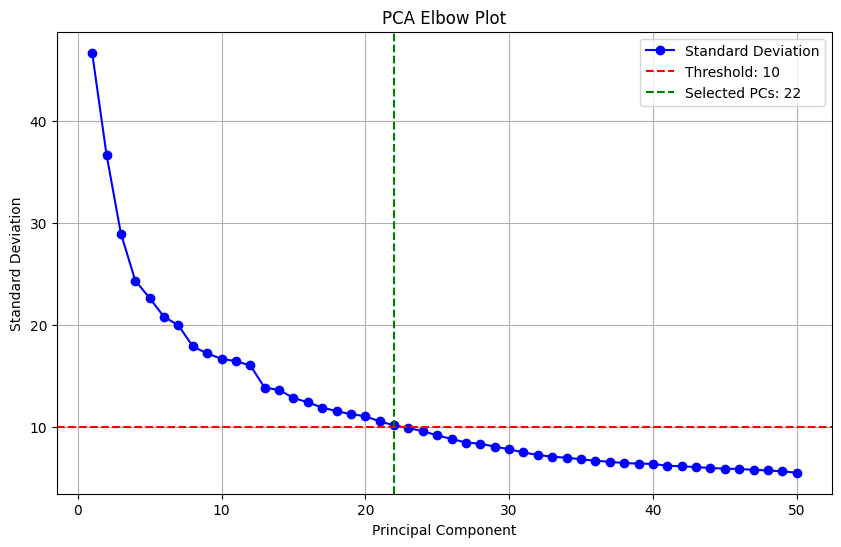

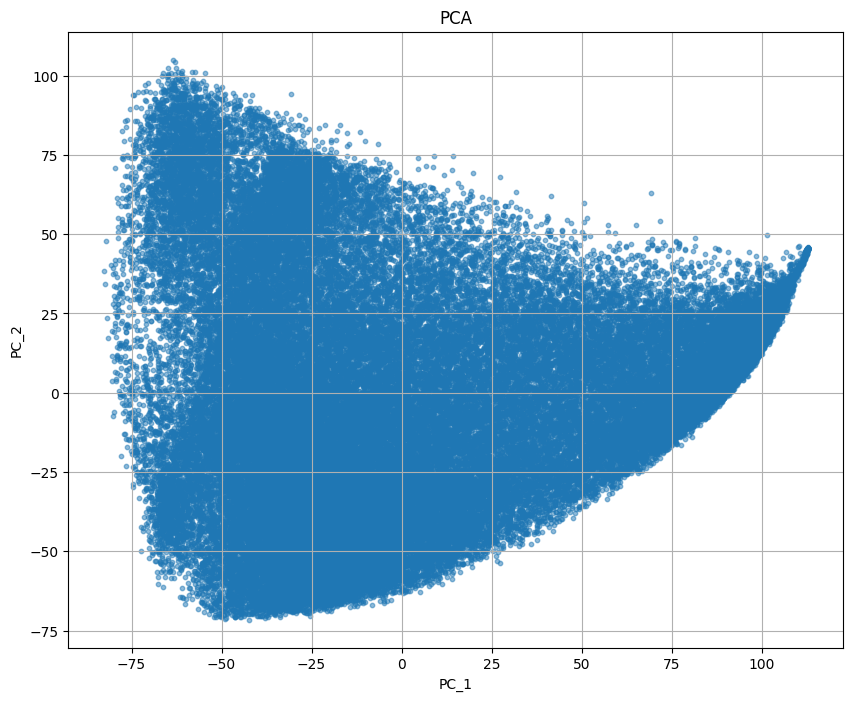

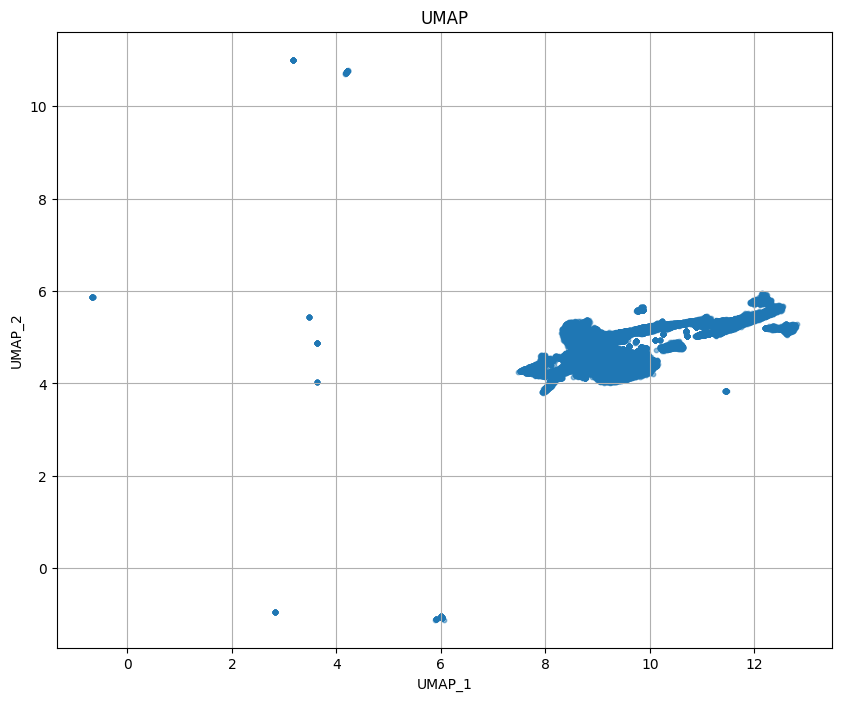

NameError: name 'tsne_matrix' is not defined

In [84]:
# Visualization
reload(dim_reduction)
# elbow plot
dim_reduction.elbow_plot(pca_object, std_dev_threshold = 10, n_components = pca_matrix.shape[1])
# visualization
dim_reduction.visualize_dim_reduction(pca_matrix.iloc[:, :2], 'PCA')
dim_reduction.visualize_dim_reduction(umap_matrix.iloc[:, :2], 'UMAP')
dim_reduction.visualize_dim_reduction(tsne_matrix.iloc[:, :2], 't-SNE')


In [27]:
# Clustering
reload(clustering)
gc.collect()
print("\tGraph based")
clustering1 = clustering.graph_based_clustering_leiden(pca_matrix, n_clusters=9)
print(clustering1.head())
print(clustering1.unique())

	Graph based
5
0.1
10
0.1
15
0.1
0.2
20
0.1
0.2
25
0.1
0.2
30
0.1
0.2
35
0.1
0.2
40
0.1
0.2
45
0.1
0.2
barcode
CID3586_AAACCTGAGAGTAATC    0
CID3586_AAACCTGAGGCTCAGA    0
CID3586_AAACCTGAGGTGACCA    0
CID3586_AAACCTGAGTCTCCTC    0
CID3586_AAACCTGAGTGTCCCG    0
dtype: int32
[0 4 1 3 2 5 7 8 6]


In [34]:
reload(clustering)
gc.collect()
print("\tDensity based")
clustering2 = clustering.density_based_clustering(umap_matrix, n_clusters=9, eps_range=(1, 1), min_samples_range=(3, 3))
print(clustering2.head())
print(clustering2.unique())

	Density based
EPS: 1.0
Min_samples: 3
Min_samples: 4
Min_samples: 5


KeyboardInterrupt: 

In [222]:
if clustering2.empty:
    print("SI")

In [50]:
reload(clustering)
gc.collect()
print("\tDistance based")
clustering3 = clustering.distance_based_clustering(pca_matrix, n_clusters=9)
print(clustering3.head())
print(clustering3.unique())

	Distance based
barcode
CID3586_AAACCTGAGAGTAATC    5
CID3586_AAACCTGAGGCTCAGA    4
CID3586_AAACCTGAGGTGACCA    4
CID3586_AAACCTGAGTCTCCTC    5
CID3586_AAACCTGAGTGTCCCG    4
dtype: int32
[5 4 2 8 0 1 7 3 6]


In [176]:
reload(clustering)
gc.collect()
print("\tHierarchical")
clustering4 = clustering.hierarchical_clustering(umap_matrix, n_clusters=11)
print(clustering4.head())
print(clustering4.unique())

	Hierarchical
barcode
AAACATACACCCAA-1    9
AAACATACCCCTCA-1    8
AAACATACCGGAGA-1    5
AAACATACTAACCG-1    1
AAACATACTCTTCA-1    7
dtype: int32
[ 9  8  5  1  7  0  4  3 10  2  6]


In [221]:
reload(clustering)
print("\tDeep Learning")
clustering5 = clustering.deep_learning_clustering(umap_matrix, n_clusters=11)
print(clustering5.head())
print(clustering5.unique())

	Deep Learning
Epoch 1/50
268/268 [==============================] - 1s 2ms/step - loss: 309.1319
Epoch 2/50
268/268 [==============================] - 0s 2ms/step - loss: 2.4160
Epoch 3/50
268/268 [==============================] - 0s 2ms/step - loss: 0.8252
Epoch 4/50
268/268 [==============================] - 0s 2ms/step - loss: 0.5554
Epoch 5/50
268/268 [==============================] - 0s 2ms/step - loss: 0.3888
Epoch 6/50
268/268 [==============================] - 0s 2ms/step - loss: 0.2821
Epoch 7/50
268/268 [==============================] - 0s 2ms/step - loss: 0.2132
Epoch 8/50
268/268 [==============================] - 0s 2ms/step - loss: 0.1661
Epoch 9/50
268/268 [==============================] - 0s 2ms/step - loss: 0.1326
Epoch 10/50
268/268 [==============================] - 0s 2ms/step - loss: 0.1103
Epoch 11/50
268/268 [==============================] - 0s 2ms/step - loss: 0.0966
Epoch 12/50
268/268 [==============================] - 0s 2ms/step - loss: 0.0881
Epoch 13

In [256]:
reload(clustering)
gc.collect()
print("\tAffinity propagation")
clustering6 = clustering.affinity_propagation_clustering(pca_matrix, n_clusters = 11, preference_range=(-100, -100), random_state=6)
print(clustering6.head())
print(len(clustering6.unique()))

	Affinity propagation
-100


c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


barcode
AAACATACACCCAA-1     605.0
AAACATACCCCTCA-1    1457.0
AAACATACCGGAGA-1    3147.0
AAACATACTAACCG-1    2484.0
AAACATACTCTTCA-1     834.0
dtype: float64
3333


In [258]:
reload(clustering)
print("\tMixture model")
clustering7 = clustering.mixture_model_clustering(pca_matrix, n_components=11)
print(clustering7.head())
print(clustering7.unique())

	Mixture model
barcode
AAACATACACCCAA-1     7
AAACATACCCCTCA-1     2
AAACATACCGGAGA-1     0
AAACATACTAACCG-1    10
AAACATACTCTTCA-1     2
dtype: int64
[ 7  2  0 10  9  4  5  3  1  6  8]


In [179]:
reload(clustering)
print("\tEnsemble")
clustering8 = clustering.ensemble_clustering(pca_matrix, n_clusters=11)
print(clustering8.head())
print(clustering8.unique())

	Ensemble
barcode
AAACATACACCCAA-1    2
AAACATACCCCTCA-1    0
AAACATACCGGAGA-1    3
AAACATACTAACCG-1    6
AAACATACTCTTCA-1    0
dtype: int64
[ 2  0  3  6  1  5 10  4  8  7]


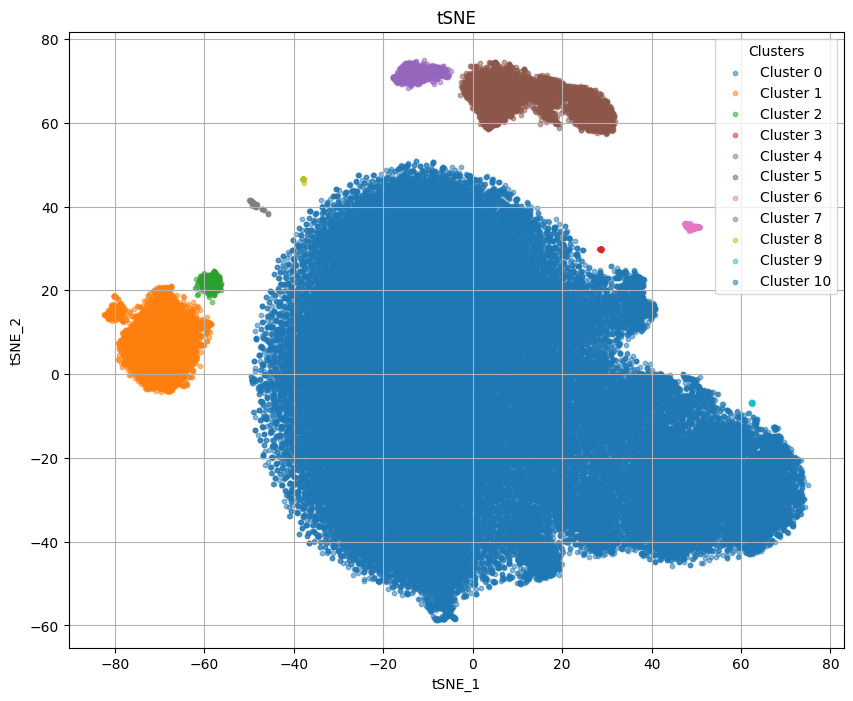

In [223]:
# Clustering visualization
reload(clustering)
clustering.visualize_clusters(tsne_matrix, 'tSNE', clustering2)

In [86]:
# Cell identification
reload(cell_identification)
gc.collect()
print("\tExpression profile")
expression_profile = cell_identification.generate_expression_profiles(expression_matrix, metadata_path, celltype_column='celltype_major', barcode_column='Unnamed: 0', sep=',')
print(expression_profile.info())
print(expression_profile.head())


	Expression profile
<class 'pandas.core.frame.DataFrame'>
Index: 29172 entries, A1BG to bP-2189O9.3
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype             
---  ------             --------------  -----             
 0   Endothelial        29172 non-null  Sparse[float64, 0]
 1   CAFs               29172 non-null  Sparse[float64, 0]
 2   PVL                29172 non-null  Sparse[float64, 0]
 3   B-cells            29172 non-null  Sparse[float64, 0]
 4   T-cells            29172 non-null  Sparse[float64, 0]
 5   Myeloid            29172 non-null  Sparse[float64, 0]
 6   Normal Epithelial  29172 non-null  Sparse[float64, 0]
 7   Plasmablasts       29172 non-null  Sparse[float64, 0]
 8   Cancer Epithelial  29172 non-null  Sparse[float64, 0]
dtypes: Sparse[float64, 0](9)
memory usage: 3.5+ MB
None
             Endothelial  CAFs  PVL  B-cells  T-cells  Myeloid  \
gene_symbol                                                      
A1BG                 1.0   1.0

In [87]:
reload(cell_identification)
gc.collect()
print("\tMarker reference")
marker_genes = cell_identification.generate_marker_reference(expression_matrix, metadata_path, celltype_column='celltype_major', barcode_column='Unnamed: 0', top_n_genes=10, sep=',')
print(list(marker_genes.items())[:5])

	Marker reference
[('Endothelial', ['MALAT1', 'IGLV4-69', 'KRT6A', 'B2M', 'EEF1A1', 'MT-CO1', 'MT-CO2', 'IGHV5-51', 'CD74', 'MT-CYB']), ('CAFs', ['IGLV2-5', 'MALAT1', 'IGLV6-57', 'COL1A1', 'COL1A2', 'B2M', 'COL3A1', 'MT-CO1', 'EEF1A1', 'FTH1']), ('PVL', ['IGLV7-43', 'MALAT1', 'IGFBP7', 'B2M', 'MT-CO1', 'MT-CO2', 'EEF1A1', 'MT-ATP6', 'MT-CO3', 'CCL19']), ('B-cells', ['MALAT1', 'CD74', 'IGKC', 'EEF1A1', 'IGLC3', 'IGLC2', 'B2M', 'MT-CO2', 'MT-CO1', 'RPLP1']), ('T-cells', ['MALAT1', 'IGLV3-24', 'IGLV1-36', 'B2M', 'IGLV3-16', 'TMSB4X', 'TPSAB1', 'EEF1A1', 'IGLV3-1', 'CCL1'])]


In [ ]:
# Cell identification
reload(cell_identification)

print("\tReference based")
cell_id_1 = cell_identification.reference_based_assignment(selected_matrix2, clustering3, expression_profile)
print(cell_id_1.head(10))
print(cell_id_1['celltype'].unique())

print("\tCorrelation based")
cell_id_2 = cell_identification.correlation_based_assignment(selected_matrix2, clustering3, expression_profile)
print(cell_id_2.head(10))
print(cell_id_2['celltype'].unique())

print("\tMarker based")
cell_id_3 = cell_identification.marker_based_assignment(selected_matrix2, clustering3, marker_genes)
print(cell_id_3.head(10))
print(cell_id_3['celltype'].unique())


	Reference based


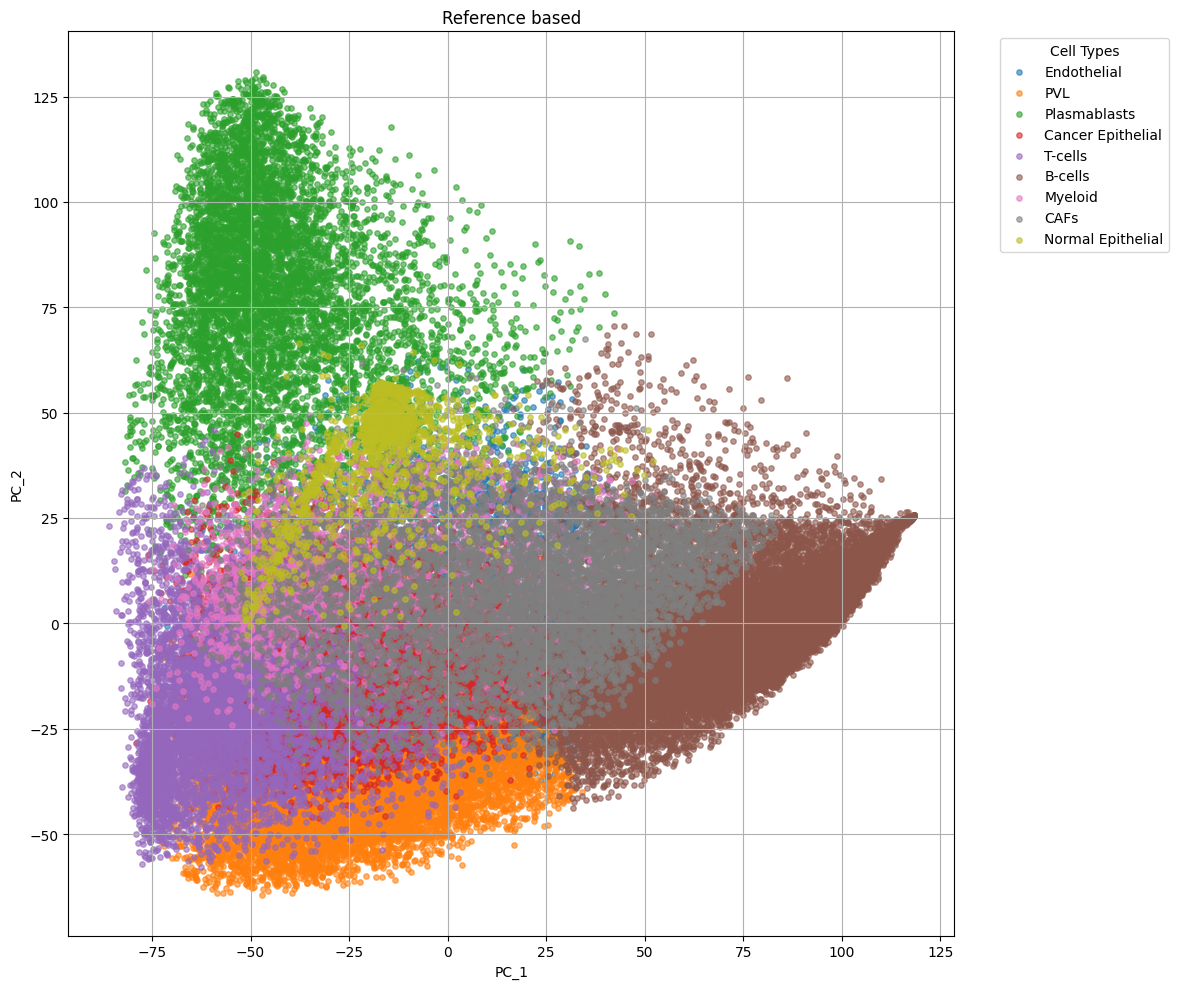

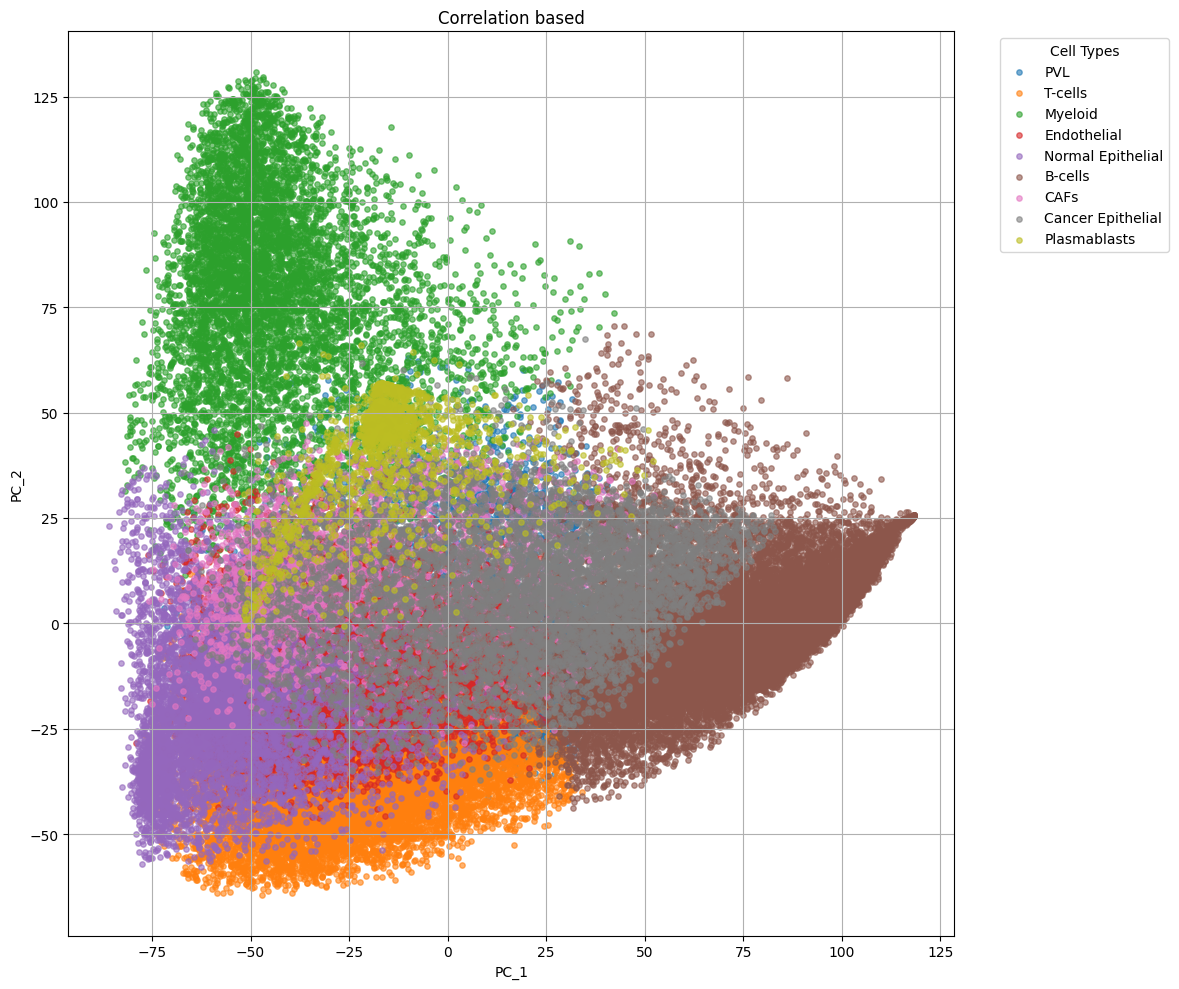

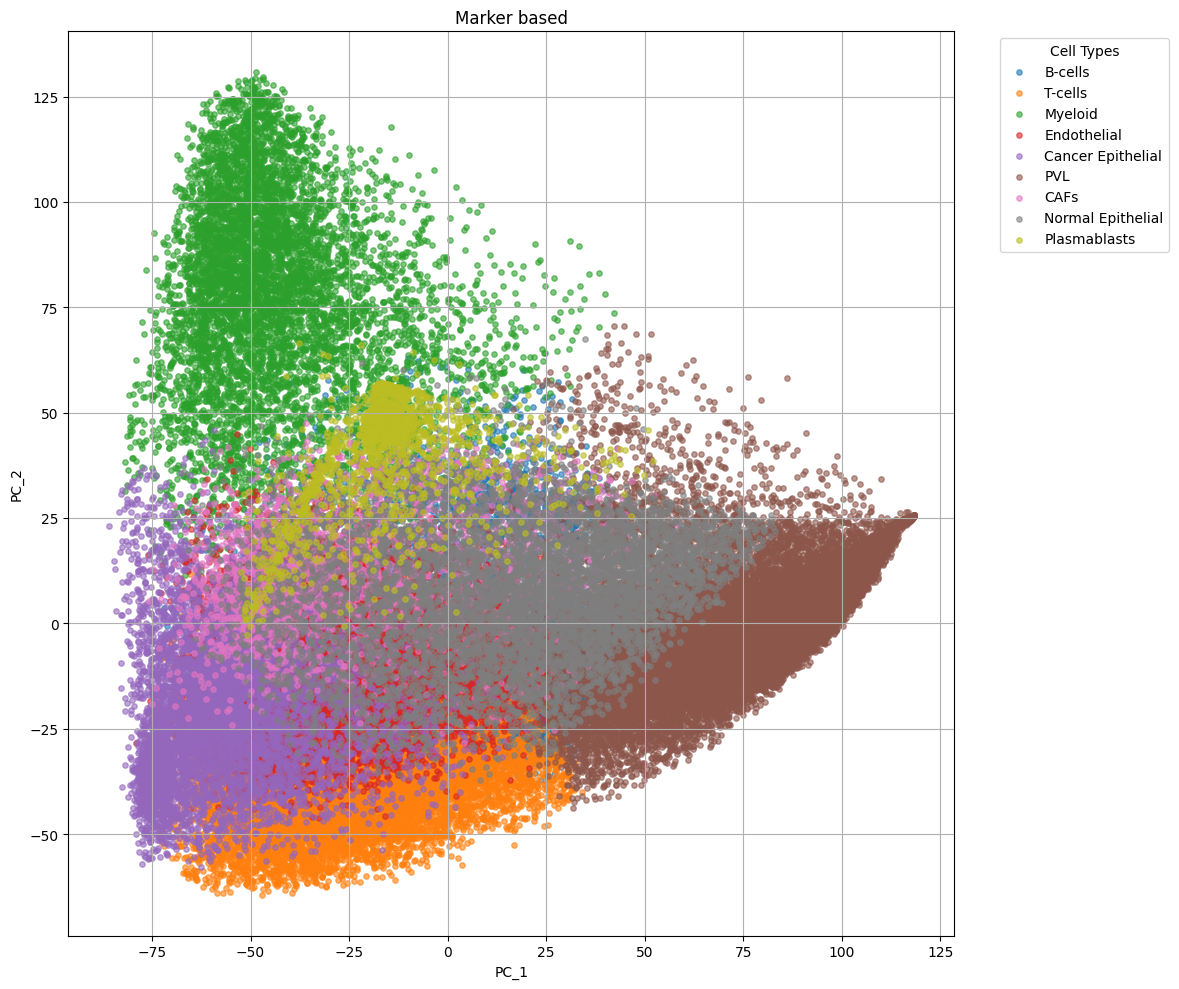

In [52]:
cell_identification.visualize_cells(pca_matrix, "Reference based", cell_id_1)
cell_identification.visualize_cells(pca_matrix, "Correlation based", cell_id_2)
cell_identification.visualize_cells(pca_matrix, "Marker based", cell_id_3)

In [55]:
# Evaluation metrics
reload(evaluation)
print("\tInternal evaluation")
internal_results = evaluation.internal_evaluation(pca_matrix, cell_id_1)
print(internal_results)

print("\tExternal evaluation")
external_results = evaluation.external_evaluation(cell_id_1, true_labels)
print(external_results)

	Internal evaluation
{'Silhouette_Score': 0.21352621136658584, 'Davies_Bouldin_Index': 1.6736589237031065, 'Calinski_Harabasz_Score': 10292.473165288566, 'ARI': 1.0, 'NMI': 1.0, 'V_measure': 1.0}
	External evaluation
{'Accuracy': 0.033406987985084936, 'Precision': 0.03144299069078762, 'Recall': 0.033406987985084936, 'F1_score': 0.024207651586080188}


In [148]:
reload(evaluation)
# Diccionario para almacenar métricas por cluster
cluster_metrics = {}

# Iterar sobre los clusters únicos
for cluster in cell_id_1['cluster'].unique():
    # Filtrar resultados y etiquetas verdaderas solo para este cluster
    cluster_results = cell_id_1[cell_id_1['cluster'] == cluster]
    cluster_true_labels = true_labels[true_labels['barcode'].isin(cluster_results['barcode'])]
    
    # Obtener el tipo celular del cluster
    cell_type = cluster_results.iloc[0]['celltype']

    # Calcular métricas para este cluster
    metrics = evaluation.external_evaluation(cluster_results, cluster_true_labels)
    
    # Guardar resultados en el diccionario con el tipo celular asociado
    cluster_metrics[cluster] = {"Cell Type": cell_type, "Metrics": metrics}

# Mostrar métricas por cluster
for cluster, data in cluster_metrics.items():
    print(f"Metrics for Cluster {cluster} ({data['Cell Type']}):")
    print(data["Metrics"])
    print("-" * 10)

Metrics for Cluster 2 (CD4+ T Helper2):
{'Accuracy': 0.002401166280764943, 'Precision': 5.765599507882549e-06, 'Recall': 0.002401166280764943, 'F1_score': 1.1503577014529627e-05}
----------
Metrics for Cluster 0 (CD4+/CD45RA+/CD25- Naive T):
{'Accuracy': 0.04606385571533025, 'Precision': 0.0021218788033627633, 'Recall': 0.04606385571533025, 'F1_score': 0.004056881980520697}
----------
Metrics for Cluster 3 (CD56+ NK):
{'Accuracy': 0.19731156985117618, 'Precision': 0.03893185559713558, 'Recall': 0.19731156985117618, 'F1_score': 0.06503212125808613}
----------
Metrics for Cluster 6 (CD4+/CD25 T Reg):
{'Accuracy': 0.00045167118337850043, 'Precision': 2.0400685789453497e-07, 'Recall': 0.00045167118337850043, 'F1_score': 4.0782951095124197e-07}
----------
Metrics for Cluster 9 (CD14+ Monocyte):
{'Accuracy': 0.00019399896533885152, 'Precision': 3.7635598552544914e-08, 'Recall': 0.00019399896533885152, 'F1_score': 7.525659740305871e-08}
----------
Metrics for Cluster 4 (CD19+ B):
{'Accuracy':

In [19]:
# Save results
import os
def save_results(pipeline_id, cell_identification_results, internal_metrics,
                 external_metrics, reduced_matrix, tissue):
    """
        Save the results of the pipeline including clustering, cell identification, and metrics.

        Parameters:
        -----------
        pipeline_id : str
            Unique identifier for the pipeline configuration.
        cell_identification_results : pd.DataFrame
            DataFrame containing 'barcode', 'cluster', and 'celltype' columns.
        internal_metrics : dict
            Dictionary containing internal evaluation metrics such as ARI, Silhouette, etc.
        external_metrics : dict
            Dictionary containing external evaluation metrics such as Accuracy, Precision, etc.
        reduced_matrix : pd.DataFrame
            Reduced dimensionality matrix (cells x dimensions).
        tissue : str
            Name of the tissue analyzed (e.g. PBMC).
        """
    # Create the results folder for the tissue if it doesn't exist
    tissue_results_path = f'results/{tissue}_results'
    os.makedirs(tissue_results_path, exist_ok=True)

    # Create the reduced matrix folder for the tissue if it doesn't exist
    tissue_reduced_matrix_path = f'{tissue_results_path}/{tissue}_reduced_matrix'
    os.makedirs(tissue_reduced_matrix_path, exist_ok=True)

    # Create a new row with the results of the pipeline
    result_row = {
        'pipeline_id': pipeline_id,  # Unique identifier for the pipeline
        'barcodes': ','.join(cell_identification_results['barcode'].tolist()),  # Convert the barcode list to a comma-separated string
        'clusters': ','.join(map(str, cell_identification_results['cluster'].tolist())),  # Convert clusters to string
        'cell_types': ','.join(cell_identification_results['celltype'].tolist()),  # Convert cell types to string
        'ARI': internal_metrics['ARI'],
        'Silhouette_Score': internal_metrics['Silhouette_Score'],
        'NMI': internal_metrics['NMI'],
        'V_measure': internal_metrics['V_measure'],
        'Accuracy': external_metrics['Accuracy'],
        'Precision': external_metrics['Precision'],
        'Recall': external_metrics['Recall'],
        'F1_score': external_metrics['F1_score']
    }

    # Save the results to a CSV file
    results_df = pd.DataFrame([result_row])

    # Check if the file already exists
    results_file_path = f'{tissue_results_path}/{tissue}_all_results.csv'
    if not os.path.exists(results_file_path):
        # If it doesn't exist, create it with headers
        results_df.to_csv(results_file_path, index=False, mode='w', header=True)
    else:
        # If it exists, append the new row without headers
        results_df.to_csv(results_file_path, index=False, mode='a', header=False)

    # Save the reduced dimensionality matrix in compressed format (CSV gzip) in the tissue-specific folder
    reduced_matrix_file_path = f'{tissue_reduced_matrix_path}/{pipeline_id}_matrix.csv.gz'
    reduced_matrix.to_csv(reduced_matrix_file_path, index=False, compression='gzip')

    print(f"Results for pipeline {pipeline_id} saved successfully.")

print("\tSave results")
pipeline_id = 'pipeline_1'
save_results(pipeline_id, cell_id_1, internal_results,
                 external_results, pca_matrix, 'PBMC')

	Save results
Results for pipeline pipeline_1 saved successfully.


In [34]:
# Execute step
def execute_step(step_name, methods_dict, method_name, data, extra_params=None):
    """
    Execute a specific step using the provided method.

    Parameters:
    -----------
    step_name : str
        The name of the pipeline step (e.g., 'data_cleaning', 'normalization', etc.).
    methods_dict : dict
        Dictionary containing methods for the current step.
    method_name : str
        The name of the method to be executed.
    data : pd.DataFrame
        The data to be processed by the method.
    extra_params : dict, optional
        Additional parameters required by the method (e.g., file paths, metadata).

    Returns:
    --------
    result : pd.DataFrame or pd.Series
        The result of the executed method.
    """
    method_entry = methods_dict[method_name]
    # Check if the dictionary contains a direct function or a sub-dictionary
    if callable(method_entry):  # Direct function
        method_func = method_entry
    else:  # Sub-dictionary with 'func' and 'params'
        method_func = method_entry['func']
        
    print(f"Running {step_name} - {method_name}")
    
    if extra_params:
        result = method_func(data, **extra_params) # If the function needs extra_params, call it with them
    else:
        result = method_func(data)  # Else, no extra_params is needed
    print(f"Execution of {step_name} - {method_name} done")
    return result

# Dictionary
data_cleaning_methods = {
    'FLEG': data_cleaning.filter_lowly_expressed_genes,
    'FHMC': data_cleaning.filter_high_mitochondrial_content,
    'FD': data_cleaning.filter_doublets_cxds,
    'CC': data_cleaning.combined_cleaning,
}

clustering_methods = {
    'GBC': {'func': clustering.graph_based_clustering_leiden, 'params': {'resolution': 1}},
    'DeBC': {'func': clustering.density_based_clustering, 'params': {'eps': 0.5, 'min_samples': 5}},
    'DiBC': {'func': clustering.distance_based_clustering, 'params': {'n_clusters': 10}},
    'HC': {'func': clustering.hierarchical_clustering, 'params': {'n_clusters': 5}},
    'DLC': {'func': clustering.deep_learning_clustering, 'params': {'n_clusters': 10, 'encoding_dim': 32}},
    'APC': {'func': clustering.affinity_propagation_clustering, 'params': None},
    'MMC': {'func': clustering.mixture_model_clustering, 'params': {'n_components': 10}},  # n_components is n_clusters
    'EC': {'func': clustering.ensemble_clustering, 'params': {'n_clusters': 11, 'eps': 0.5, 'min_samples': 5}},
}

for cluster_method, cluster_config in clustering_methods.items():
    result_step = execute_step('Clustering', clustering_methods, cluster_method, pca_matrix, cluster_config.get('params'))
    print(result_step.info())


Running Clustering - GBC
Execution of Clustering - GBC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
Series name: None
Non-Null Count  Dtype
--------------  -----
1000 non-null   int32
dtypes: int32(1)
memory usage: 44.0+ KB
None
Running Clustering - DeBC
Execution of Clustering - DeBC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
Series name: None
Non-Null Count  Dtype
--------------  -----
1000 non-null   int64
dtypes: int64(1)
memory usage: 47.9+ KB
None
Running Clustering - DiBC
Execution of Clustering - DiBC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
Series name: None
Non-Null Count  Dtype
--------------  -----
1000 non-null   int32
dtypes: int32(1)
memory usage: 44.0+ KB
None
Running Clustering - HC
Execution of Clustering - HC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCC

In [227]:
# Main pipeline
import pandas as pd
import scipy.io
import numpy as np
import scipy.sparse
import os
import src.preprocessing.data_cleaning as data_cleaning
import src.preprocessing.normalization as normalization
import src.preprocessing.feature_selection as feature_selection
import src.preprocessing.dim_reduction as dim_reduction
import src.analysis.clustering as clustering
import src.analysis.cell_identification as cell_identification
import src.evaluation.evaluation as evaluation

reload(data_cleaning)
reload(normalization)
reload(feature_selection)
reload(dim_reduction)
reload(clustering)
reload(cell_identification)
reload(evaluation)

def load_expression_data_from_mtx(path, barcodes_labeled=None, n_sample=None, random_state=6):
    """
    Load gene expression data from MTX format into a sparse DataFrame.

    Parameters:
    - path: str, path to the folder with the matrix, genes and barcodes.

    Returns:
    - expression_matrix: Sparse DataFrame containing gene expression data.
    """
    # Load expression matrix
    matrix = scipy.io.mmread(path+"matrix.mtx").tocsc()

    # Load genes
    genes = pd.read_csv(path+"genes.tsv", header=None, sep='\t', names=['gene_id', 'gene_symbol'])

    # Load barcodes
    barcodes = pd.read_csv(path+"barcodes.tsv", header=None, sep='\t', names=['barcode'])

    # Filter by labeled barcodes if barcodes_labeled is provided
    if barcodes_labeled is not None:
        if 'barcode' not in barcodes_labeled.columns:
            raise ValueError("The provided barcodes_labeled DataFrame must contain a 'barcode' column.")
        # Find the intersection of barcodes
        labeled_barcodes = set(barcodes_labeled['barcode'])
        matching_indices = barcodes['barcode'].isin(labeled_barcodes)
        matrix = matrix[:, matching_indices]
        barcodes = barcodes[matching_indices]

    # Apply random sampling to barcodes if n_sample is specified
    if n_sample is not None and n_sample < len(barcodes):
        np.random.seed(random_state)
        sampled_indices = np.random.choice(len(barcodes), size=n_sample, replace=False)
        matrix = matrix[:, sampled_indices]  # Subset columns (barcodes)
        barcodes = barcodes.iloc[sampled_indices]

    # Transform sparse matrix into pandas sparse DataFrame
    expression_matrix = pd.DataFrame.sparse.from_spmatrix(matrix)
    expression_matrix.index = genes['gene_symbol']
    expression_matrix.columns = barcodes['barcode']

    expression_matrix = data_cleaning.remove_duplicated_genes(expression_matrix)

    return expression_matrix


def load_expression_data_from_csv(csv_path, chunk_size=10000):
    """
    Read a large CSV file in chunks, transpose, convert to sparse, and concatenate to avoid RAM overloading.

    Parameters:
    - csv_path: str, path to the CSV file.
    - chunk_size: int, number of rows to read in each chunk.

    Returns:
    - expression_matrix: Sparse DataFrame containing the full gene expression data.
    """
    # Initialize a list to store processed chunks
    processed_chunks = []

    # Read the CSV in chunks
    for chunk in pd.read_csv(csv_path, sep=',', chunksize=chunk_size, header=0, index_col=0):
        # Transpose the chunk so rows are genes and columns are barcodes
        chunk = chunk.T

        # Convert to Sparse DataFrame
        sparse_chunk = pd.DataFrame.sparse.from_spmatrix(scipy.sparse.csr_matrix(chunk))

        # Add the processed chunk to the list
        processed_chunks.append(sparse_chunk)

        # Free memory from the current chunk
        del chunk  # Optional, to ensure the original chunk memory is freed

    # Concatenate all processed chunks into a single Sparse DataFrame
    expression_matrix = pd.concat(processed_chunks, axis=1)

    # Free memory from the processed chunks
    del processed_chunks

    # Return the complete Sparse DataFrame
    return expression_matrix


def save_results(results_path, pipeline_id, cell_identification_results, internal_metrics,
                 external_metrics, reduced_matrix, tissue):
    """
        Save the results of the pipeline including clustering, cell identification, and metrics.

        Parameters:
        -----------
        results_path : str
            Folder to save the results in.
        pipeline_id : str
            Unique identifier for the pipeline configuration.
        cell_identification_results : pd.DataFrame
            DataFrame containing 'barcode', 'cluster', and 'celltype' columns.
        internal_metrics : dict
            Dictionary containing internal evaluation metrics such as ARI, Silhouette, etc.
        external_metrics : dict
            Dictionary containing external evaluation metrics such as Accuracy, Precision, etc.
        reduced_matrix : pd.DataFrame
            Reduced dimensionality matrix (cells x dimensions).
        tissue : str
            Name of the tissue analyzed (e.g. PBMC).
        """
    # Create the results folder for the tissue if it doesn't exist
    tissue_results_path = f'{results_path}/{tissue}_results'
    os.makedirs(tissue_results_path, exist_ok=True)

    # Create the reduced matrix folder for the tissue if it doesn't exist
    tissue_reduced_matrix_path = f'{tissue_results_path}/{tissue}_reduced_matrix'
    os.makedirs(tissue_reduced_matrix_path, exist_ok=True)

    # Create a new row with the results of the pipeline
    result_row = {
        'pipeline_id': pipeline_id,  # Unique identifier for the pipeline
        'barcodes': ','.join(cell_identification_results['barcode'].tolist()),  # Convert the barcode list to a comma-separated string
        'clusters': ','.join(map(str, cell_identification_results['cluster'].tolist())),  # Convert clusters to string
        'cell_types': ','.join(cell_identification_results['celltype'].tolist()),  # Convert cell types to string
        'Silhouette_Score': internal_metrics['Silhouette_Score'],
        'Davies_Bouldin_Index': internal_metrics['Davies_Bouldin_Index'],
        'Calinski_Harabasz_Score': internal_metrics['Calinski_Harabasz_Score'],
        'ARI': internal_metrics['ARI'],
        'NMI': internal_metrics['NMI'],
        'V_measure': internal_metrics['V_measure'],
        'Accuracy': external_metrics['Accuracy'],
        'Precision': external_metrics['Precision'],
        'Recall': external_metrics['Recall'],
        'F1_score': external_metrics['F1_score']
    }

    # Save the results to a CSV file
    results_df = pd.DataFrame([result_row])

    # Check if the file already exists
    results_file_path = f'{tissue_results_path}/{tissue}_all_results.csv'
    if not os.path.exists(results_file_path):
        # If it doesn't exist, create it with headers
        results_df.to_csv(results_file_path, index=False, mode='w', header=True)
    else:
        # If it exists, append the new row without headers
        results_df.to_csv(results_file_path, index=False, mode='a', header=False)

    # Save the reduced dimensionality matrix in compressed format (CSV gzip) in the tissue-specific folder
    reduced_matrix_file_path = f'{tissue_reduced_matrix_path}/{pipeline_id}_matrix.csv.gz'
    reduced_matrix.to_csv(reduced_matrix_file_path, index=False, compression='gzip')

    print(f"Results for pipeline {pipeline_id} saved successfully.")


def generate_pipeline_id(methods_list):
    """
    Generate a unique pipeline ID based on the methods used.

    Parameters:
    -----------
    methods_list : list of str
        List of method names used in the pipeline.

    Returns:
    --------
    pipeline_id : str
        Unique pipeline identifier.
    """
    return "_".join(methods_list)


def execute_step(step_name, methods_dict, method_name, data, extra_params=None):
    """
    Execute a specific step using the provided method.

    Parameters:
    -----------
    step_name : str
        The name of the pipeline step (e.g., 'data_cleaning', 'normalization', etc.).
    methods_dict : dict
        Dictionary containing methods for the current step.
    method_name : str
        The name of the method to be executed.
    data : pd.DataFrame
        The data to be processed by the method.
    extra_params : dict, optional
        Additional parameters required by the method (e.g., file paths, metadata).

    Returns:
    --------
    result : pd.DataFrame or pd.Series
        The result of the executed method.
    """
    method_entry = methods_dict[method_name]
    # Check if the dictionary contains a direct function or a sub-dictionary
    if callable(method_entry):  # Direct function
        method_func = method_entry
    else:  # Sub-dictionary with 'func' and 'params'
        method_func = method_entry['func']

    print(f"Running {step_name} - {method_name}")

    if extra_params:
        result = method_func(data, **extra_params)  # If the function needs extra_params, call it with them
    else:
        result = method_func(data)  # Else, no extra_params is needed
    print(f"Execution of {step_name} - {method_name} done")
    return result


# Dictionaries to execute methods in pipeline
data_cleaning_methods = {
    'FLEG': data_cleaning.filter_lowly_expressed_genes,
    'FHMC': data_cleaning.filter_high_mitochondrial_content,
    'FD': data_cleaning.filter_doublets_cxds,
    'CC': data_cleaning.combined_cleaning
}

normalization_methods = {
    "CPM": normalization.normalize_cpm,
    "QR": normalization.normalize_quantile_regression,
    "NB": normalization.normalize_negative_binomial
}

feature_selection_methods = {
    'SHVG': feature_selection.select_highly_variable_genes,
    'SGbV': feature_selection.select_genes_by_variance
}

dim_reduction_methods = {
    'PCA': dim_reduction.apply_pca,
    'UMAP': dim_reduction.apply_umap,
    'TSNE': dim_reduction.apply_tsne
}

# TO DO: adjust params
clustering_methods = {
    'GBC': {'func': clustering.graph_based_clustering_leiden, 'params': {'n_clusters': 11}},
    'DeBC': {'func': clustering.density_based_clustering, 'params': {'n_clusters': 11}},
    'DiBC': {'func': clustering.distance_based_clustering, 'params': {'n_clusters': 11}},
    'HC': {'func': clustering.hierarchical_clustering, 'params': {'n_clusters': 11}},
    'DLC': {'func': clustering.deep_learning_clustering, 'params': {'n_clusters': 11}},
    'MMC': {'func': clustering.mixture_model_clustering, 'params': {'n_components': 11}},  # n_components is n_clusters
    'EC': {'func': clustering.ensemble_clustering, 'params': {'n_clusters': 11}}
}

cell_identification_methods = {
    'RBA': cell_identification.reference_based_assignment,
    'CBA': cell_identification.correlation_based_assignment,
    'MBA': cell_identification.marker_based_assignment
}



### Main Pipeline ###
# Change params of dictionaries if needed
tissue = 'PBMC'
metadata_path = "./data/PBMC/PBMC_68k/hg19/68k_pbmc_barcodes_annotation.tsv"
results_path = "./results"
celltype_column = 'celltype'
pca_threshold = {'threshold': 5}

print(f"Starting analysis for", tissue)

# Load true labels
true_labels = evaluation.load_true_labels(metadata_path, 'barcodes', celltype_column, "\t")

# Load expression matrix
expression_matrix = load_expression_data_from_mtx("./data/PBMC/PBMC_68k/hg19/", barcodes_labeled=true_labels, n_sample=1000, random_state=6)

# Generate reference data for cell identification
expression_profile = cell_identification.generate_expression_profiles(expression_matrix, metadata_path, celltype_column=celltype_column, sep='\t')
marker_genes = cell_identification.generate_marker_reference(expression_matrix, metadata_path, celltype_column=celltype_column, sep='\t')

print(expression_matrix.info())

for cleaning_method in data_cleaning_methods.keys():
    cleaned_matrix = execute_step('data_cleaning', data_cleaning_methods, cleaning_method, expression_matrix)

    for norm_method in normalization_methods.keys():
        normalized_matrix = execute_step('normalization', normalization_methods, norm_method, cleaned_matrix)

        for fs_method in feature_selection_methods.keys():
            selected_matrix = execute_step('feature_selection', feature_selection_methods, fs_method, normalized_matrix)

            for dr_method in dim_reduction_methods.keys():
                # If tSNE, execute with predefined 2 dimensions
                if dr_method == 'TSNE':
                    reduced_matrix = execute_step('dim_reduction', dim_reduction_methods, dr_method,
                                 selected_matrix)
                else:  # PCA or UMAP
                    # Execute PCA
                    pca_object, reduced_matrix = execute_step('dim_reduction', dim_reduction_methods, 'PCA',
                                                            selected_matrix, pca_threshold)
                    # If dr_method == PCA, continue, this step is already done
                    # else, if dr_method == UMAP, execute umap with the same number of dimensions as PCA
                    if dr_method == 'UMAP':
                        optimal_num_dimensions = {'n_components': reduced_matrix.shape[1]}  # Get the number of components (columns)
                        reduced_matrix = execute_step('dim_reduction', dim_reduction_methods, dr_method,
                                                    selected_matrix, optimal_num_dimensions)

                for cluster_method, cluster_config in clustering_methods.items():
                    # Skip DBSCAN for UMAP, bc it is too dense and can't hold it with my hardware
                    if dr_method == 'UMAP' and cluster_method == 'DeBC':
                        continue

                    # Perform clustering
                    clustering_results = execute_step('clustering', clustering_methods, cluster_method, reduced_matrix,
                                                      cluster_config['params'])

                    # If no clusters, skip and continue with the next clustering method
                    if clustering_results.empty:
                        print("No clusters formed, skipping this clustering method")
                        continue

                    for cell_id_method in cell_identification_methods.keys():
                        # For marker_based_assignment, marker reference is needed
                        if cell_id_method == 'MBA':
                            extra_params = {'cluster_results': clustering_results, 'marker_reference': marker_genes}
                        # For the other 2 methods, expression_profile is needed
                        else:
                            extra_params = {'cluster_results': clustering_results, 'expression_profile': expression_profile}

                        cell_identification_results = execute_step('cell_identification', cell_identification_methods, cell_id_method, selected_matrix, extra_params)

                        # Internal Evaluation
                        internal_metrics = evaluation.internal_evaluation(reduced_matrix, cell_identification_results)

                        # External Evaluation
                        external_metrics = evaluation.external_evaluation(cell_identification_results, true_labels)

                        # Generate unique pipeline identifier
                        pipeline_id = generate_pipeline_id([
                            cleaning_method, norm_method, fs_method, dr_method, cluster_method, cell_id_method
                        ])

                        # Save results
                        save_results(
                            results_path=results_path,
                            pipeline_id=pipeline_id,
                            cell_identification_results=cell_identification_results,
                            internal_metrics=internal_metrics,
                            external_metrics=external_metrics,
                            reduced_matrix=reduced_matrix,
                            tissue=tissue
                        )

print("Finish!")

Starting analysis for PBMC
<class 'pandas.core.frame.DataFrame'>
Index: 12806 entries, RP11-206L10.2 to SRSF10
Columns: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
dtypes: Sparse[float64, 0](1000)
memory usage: 6.2+ MB
None
Running data_cleaning - FLEG
Execution of data_cleaning - FLEG done
Running normalization - CPM
Execution of normalization - CPM done
Running feature_selection - SHVG
Execution of feature_selection - SHVG done
Running dim_reduction - PCA
Execution of dim_reduction - PCA done
Running clustering - GBC
Execution of clustering - GBC done
Running cell_identification - RBA
Execution of cell_identification - RBA done
Results for pipeline FLEG_CPM_SHVG_PCA_GBC_RBA saved successfully.
Running cell_identification - CBA
Execution of cell_identification - CBA done
Results for pipeline FLEG_CPM_SHVG_PCA_GBC_CBA saved successfully.
Running cell_identification - MBA
Execution of cell_identification - MBA done
Results for pipeline FLEG_CPM_SHVG_PCA_GBC_MBA saved successfully

TypeError: sequence item 5: expected str instance, NoneType found

In [266]:
import os
import numpy as np
from scipy.sparse import coo_matrix, vstack
from scipy.io import mmread, mmwrite
import pandas as pd

# Base directory and folder names
base_dir = "./data/Tumor/"
folders = ["CID3586", "CID3838", "CID3921", "CID3941", "CID3946", "CID3948",
           "CID3963", "CID4040", "CID4066", "CID4465", "CID4495", "CID44041",
           "CID4067", "CID4398", "CID4461", "CID4463", "CID4513", "CID4515",
           "CID4523", "CID4535", "CID4471"]

# Initialize variables to keep track of combined data
gene_index_map = {}  # Map from gene to row index
all_data = []  # List of sparse matrices
all_cells = set()  # To collect all unique barcodes
all_genes = set()
current_row_offset = 0

# First pass: Collect all unique cell barcodes and genes
for folder in folders:
    cells_file = os.path.join(base_dir, folder, "count_matrix_barcodes.tsv")
    cells = pd.read_csv(cells_file, header=None, sep="\t", names=["cell_id"])["cell_id"].tolist()
    all_cells.update(cells)
    genes_file = os.path.join(base_dir, folder, "count_matrix_genes.tsv")
    genes = pd.read_csv(genes_file, header=None, sep="\t", names=["gene_id"])["gene_id"].tolist()
    all_genes.update(genes)

# Create a mapping from barcode and gene to column index
all_cells = sorted(all_cells)  # Ensure consistent order
cell_index_map = {cell: idx for idx, cell in enumerate(all_cells)}
total_cells = len(all_cells)

all_genes = sorted(all_genes) 
gene_index_map = {gene: idx for idx, gene in enumerate(all_genes)}
total_genes = len(all_genes)

print(f"Total unique cells: {total_cells}")
print(f"Total unique genes: {total_genes}")

# Iterate through folders and process matrices
for i, folder in enumerate(folders):
    folder_path = os.path.join(base_dir, folder)
    mtx_file = os.path.join(folder_path, "count_matrix_sparse.mtx")

    print(f"Processing folder {i + 1}/{len(folders)}: {folder}")

    # Read sparse matrix from the file
    matrix = mmread(mtx_file).tocoo()
    print("matrix read")
    
    # Load gene and cell information (assuming rows = genes, cols = cells)
    genes_file = os.path.join(folder_path, "count_matrix_genes.tsv")  # File containing gene names
    cells_file = os.path.join(folder_path, "count_matrix_barcodes.tsv")  # File containing cell barcodes

    genes = pd.read_csv(genes_file, header=None, sep="\t", names=["gene_id"])["gene_id"].tolist()
    cells = pd.read_csv(cells_file, header=None, sep="\t", names=["cell_id"])["cell_id"].tolist()

    # Map genes to a global index and adjust row indices of the matrix
    new_rows = []
    for row_index in matrix.row:
        gene = genes[row_index]  # Get the gene name corresponding to the row index
        if gene not in gene_index_map:
            gene_index_map[gene] = current_row_offset
            current_row_offset += 1
        new_rows.append(gene_index_map[gene])

   # Map cells to a global index and adjust column indices of the matrix
    new_cols = [cell_index_map[cells[col]] for col in matrix.col]

    # Convert new_rows and new_cols to NumPy arrays
    new_rows = np.array(new_rows)
    new_cols = np.array(new_cols)

    # Create a new sparse matrix with aligned row and column indices
    updated_matrix = coo_matrix((matrix.data, (new_rows, new_cols)), 
                                shape=(total_genes, total_cells))

    # Append updated matrix to the list
    all_data.append(updated_matrix)

    print(f"Finished processing folder {folder}. Current total genes: {current_row_offset}")

# Combine all matrices vertically
print("Combining all matrices into a single matrix...")
combined_matrix = sum(all_data)  # Sum overlapping rows by adding matrices
print(f"Combined matrix dimensions: {combined_matrix.shape[0]} rows, {combined_matrix.shape[1]} columns")

# Save the final matrix
output_file = os.path.join(base_dir, "all_matrix.mtx")
mmwrite(output_file, combined_matrix)

# Save the gene and cell lists
gene_list = [gene for gene, _ in sorted(gene_index_map.items(), key=lambda x: x[1])]
pd.DataFrame(["genes"] + gene_list).to_csv(os.path.join(base_dir, "all_genes.tsv"), header=False, index=False, sep="\t")
pd.DataFrame(["barcodes"] + all_cells).to_csv(os.path.join(base_dir, "all_barcodes.tsv"), header=False, index=False, sep="\t")

print("All matrices have been successfully combined and saved.")

Total unique cells: 72410
Total unique genes: 29733
Processing folder 1/21: CID3586
matrix read
Finished processing folder CID3586. Current total genes: 0
Processing folder 2/21: CID3838
matrix read
Finished processing folder CID3838. Current total genes: 0
Processing folder 3/21: CID3921
matrix read
Finished processing folder CID3921. Current total genes: 0
Processing folder 4/21: CID3941
matrix read
Finished processing folder CID3941. Current total genes: 0
Processing folder 5/21: CID3946
matrix read
Finished processing folder CID3946. Current total genes: 0
Processing folder 6/21: CID3948
matrix read
Finished processing folder CID3948. Current total genes: 0
Processing folder 7/21: CID3963
matrix read
Finished processing folder CID3963. Current total genes: 0
Processing folder 8/21: CID4040
matrix read
Finished processing folder CID4040. Current total genes: 0
Processing folder 9/21: CID4066
matrix read
Finished processing folder CID4066. Current total genes: 0
Processing folder 10/

In [273]:
def load_expression_data_from_mtx(path, matrix_name, genes_name, barcodes_name):
    """
    Load gene expression data from MTX format into a sparse DataFrame.

    Parameters:
    - path: str, path to the folder with the matrix, genes and barcodes.

    Returns:
    - expression_matrix: Sparse DataFrame containing gene expression data.
    """
    # Load expression matrix
    matrix = scipy.io.mmread(path+matrix_name)
    print("Matrix read")

    # Load genes
    genes = pd.read_csv(path+genes_name, header=0, sep='\t', names=['genes'])
    print("Genes read")

    # Load barcodes
    barcodes = pd.read_csv(path+barcodes_name, header=0, sep='\t', names=['barcodes'])
    print("Barcodes read")

    # Transform sparse matrix into pandas sparse DataFrame
    expression_matrix = pd.DataFrame.sparse.from_spmatrix(matrix)
    expression_matrix.index = genes['genes']
    expression_matrix.columns = barcodes['barcodes']

    expression_matrix = data_cleaning.remove_duplicated_genes(expression_matrix)

    return expression_matrix
    
expression_matrix_tumor = load_expression_data_from_mtx("./data/Tumor/",
                                                        matrix_name = "all_matrix.mtx",
                                                        genes_name = "all_genes.tsv",
                                                        barcodes_name= "all_barcodes.tsv")
print(expression_matrix_tumor.info())

duplicated_genes = expression_matrix.index[expression_matrix.index.duplicated()]
if len(duplicated_genes) > 0:
    print(f"Genes duplicados encontrados: {duplicated_genes}")
else:
     print("No hay genes duplicados")


Matrix read
Genes read
Barcodes read
<class 'pandas.core.frame.DataFrame'>
Index: 29733 entries, A1BG to bP-2189O9.3
Columns: 72410 entries, CID3586_AAACCTGAGAGTAATC to CID4535_TTTGTCATCTTTAGTC
dtypes: Sparse[int64, 0](72410)
memory usage: 1.4+ GB
None
barcodes  CID3586_AAACCTGAGAGTAATC  CID3586_AAACCTGAGGCTCAGA  \
genes                                                          
A1BG                             1                         0   
A1BG-AS1                         0                         0   
A1CF                             0                         0   
A2M                              0                         0   
A2M-AS1                          0                         0   

barcodes  CID3586_AAACCTGAGGTGACCA  CID3586_AAACCTGAGTCTCCTC  \
genes                                                          
A1BG                             0                         0   
A1BG-AS1                         0                         0   
A1CF                             0        

In [283]:
metadata_path_tumor = "./data/Tumor/metadata_all.csv"
true_labels_tumor = evaluation.load_true_labels(metadata_path_tumor, 'Unnamed: 0', 'celltype_major', ',')
print(true_labels_tumor.info())
print(true_labels_tumor.head())
print(true_labels_tumor['true_label'].unique())
print(len(true_labels_tumor['true_label'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72410 entries, 0 to 72409
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   barcode     72410 non-null  object
 1   true_label  72410 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None
                    barcode   true_label
0  CID3586_AAGACCTCAGCATGAG  Endothelial
1  CID3586_AAGGTTCGTAGTACCT  Endothelial
2  CID3586_ACCAGTAGTTGTGGCC  Endothelial
3  CID3586_ACCCACTAGATGTCGG  Endothelial
4  CID3586_ACTGATGGTCAACTGT  Endothelial
['Endothelial' 'CAFs' 'PVL' 'B-cells' 'T-cells' 'Myeloid'
 'Normal Epithelial' 'Plasmablasts' 'Cancer Epithelial']
9


In [ ]:
import pandas as pd
import scipy.sparse
import joblib

# Ruta al archivo CSV
csv_path = "../data/Neuronal/M1/matrix.csv"

def read_and_process_csv_in_chunks(csv_path, chunk_size=10000, output_file='../data/Neuronal/M1/sparse_dataframe.joblib'):
    """
    Read a large CSV file in chunks, transpose, convert to sparse, and concatenate.

    Parameters:
    - csv_path: str, path to the CSV file.
    - chunk_size: int, number of rows to read in each chunk.

    Returns:
    - sparse_expression_matrix: Sparse DataFrame containing the full gene expression data.
    """
    # Initialize a list to store processed chunks
    processed_chunks = []
    genes = None
    barcodes = []
    print(f"Empezamos", flush=True)
    
    # Read the CSV in chunks
    for chunk in pd.read_csv(csv_path, sep=',', chunksize=chunk_size,  header=0, index_col=0):
        print(f"Processing chunk rows {chunk.index[0]} to {chunk.index[-1]}...", flush=True)

        # Keep genes
        if genes is None:
            genes = chunk.columns.tolist()
        
        # Keep barcodes
        barcodes.extend(chunk.index.tolist())
        
        # Transpose the chunk so rows are genes and columns are barcodes
        chunk = chunk.T
        
        # Convert to Sparse DataFrame
        sparse_chunk = scipy.sparse.csr_matrix(chunk)
        
        # Add the processed chunk to the list
        processed_chunks.append(sparse_chunk)
        
        # Free memory from the current chunk
        del chunk  # Optional, to ensure the original chunk memory is freed
        
    # Concatenate all processed chunks into a single Sparse DataFrame
    full_sparse_matrix = scipy.sparse.vstack(processed_chunks)
    sparse_expression_matrix = pd.DataFrame.sparse.from_spmatrix(
        full_sparse_matrix,
        index=genes,
        columns=barcodes
    )

    joblib.dump(sparse_expression_matrix, output_file)
    
    # Return the complete Sparse DataFrame
    return sparse_expression_matrix

def load_sparse_dataframe(input_file='../data/Neuronal/M1/sparse_dataframe.joblib'):
    return joblib.load(input_file)


# Read and process the CSV in chunks
sparse_matrix = read_and_process_csv_in_chunks(csv_path)

sparse_dataframe = load_sparse_dataframe('../data/Neuronal/M1/sparse_dataframe.joblib')

# Show column names (First 10)
print("Column Names Matrix (First 10):", sparse_matrix.columns[:10])

# Show head of the Sparse Expression Matrix
print("\nHead of the Sparse Expression Matrix:")
print(sparse_matrix.head())

# Show data types of the Sparse Expression Matrix
print("\nData Types of the Sparse Expression Matrix:")
print(sparse_matrix.dtypes)

# Show shape of the Sparse Expression Matrix
print("\nShape of the Sparse Expression Matrix:", sparse_matrix.shape)

# Mostrar información
print("Dimensiones de la matriz:", sparse_dataframe.shape)
print("\nPrimeros 5 genes:", sparse_dataframe.index[:5])
print("\nPrimeros 5 barcodes:", sparse_dataframe.columns[:5])
print("\nMuestra de la matriz:")
print(sparse_dataframe.iloc[:5, :5])

Empezamos
Processing chunk rows AAACCCAAGGATTTCC-LKTX_190129_01_A01 to ATCGCCTTCACTGGGC-LKTX_190129_01_C01...
Processing chunk rows ATCGCCTTCGAGAAAT-LKTX_190129_01_C01 to CATCCACAGGCCGCTT-LKTX_190129_01_E01...
Processing chunk rows CATCCACCAAATGCGG-LKTX_190129_01_E01 to TTTCGATCACCATTCC-LKTX_190129_01_F01...
Processing chunk rows TTTCGATCATACATCG-LKTX_190129_01_F01 to TCGCTTGGTTTACGTG-LKTX_190130_01_A01...
